# Playground

In [1]:
import numpy as np
import csv
import keras

from keras.utils import np_utils

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

image_width = 480
image_height = 480
image_depth = 1

num_classes = 3
categories_name = ['Background', 'Cosmic', 'Beam']
categories_value = [0, 1, 2]

# Total: 10620
n_training = 30
training_feature_file = "input_files/training/feature_w.csv"
training_label_file = "input_files/training/label_w.csv"

# Total: 1320
n_validation = 10
validation_feature_file = "input_files/validation/feature_w.csv"
validation_label_file = "input_files/validation/label_w.csv"

# Total: 1330
n_testing = 10
testing_feature_file = "input_files/testing/feature_w.csv"
testing_label_file = "input_files/testing/label_w.csv"

print(keras.__version__)

Using TensorFlow backend.


2.2.4


In [22]:
def plot_weights(weights, ranges, plot_name):
    fig, axes = plt.subplots(1, len(categories_value), figsize=(18,5), facecolor='w')
    for index, value in enumerate(categories_value):
        ax = axes[index]
        ax.hist(weights[index], 100, range=ranges[index], color='green', alpha=0.75)
        ax.set_title(categories_name[index], fontsize=20, fontname='Georgia',fontweight='bold')
        ax.set_xlabel("Weight", fontsize=15, fontname='Georgia',fontweight='bold')
        ax.set_ylabel("Count", fontsize=15, fontname='Georgia',fontweight='bold')
        
        _, max_ = ax.get_ylim()
        median = np.median(weights[index])
        ax.axvline(median, color='k', linestyle='dashed', linewidth=2)
        ax.text(median + median/10, max_ - max_/10, 'Median: {:.2f}'.format(median), 
                fontsize=12, fontweight=1000, color='k')

    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')
    
def get_feature_image(feature_image, fig, ax, title):
    c = ax.imshow(feature_image, cmap='winter_r',interpolation='none', origin='lower', 
                  norm=LogNorm(vmin=1.0, vmax=abs(feature_image).max()))
    fig.colorbar(c, ax=ax)
    ax.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
    ax.set_title(title, fontsize=20,fontname='Georgia',fontweight='bold')
    
def get_label_image(label_image, fig, ax, title):
    minimum = np.min(label_image)
    maximum = np.max(label_image)
    cmap = plt.get_cmap('gist_heat_r', maximum-minimum+1)
    c= ax.imshow(label_image,cmap=cmap,interpolation='none', origin='lower', 
                   vmin=minimum, vmax=maximum)
    cb = fig.colorbar(c, ax=ax)
    cb.set_ticks(categories_value)
    cb.set_ticklabels(categories_name) 
    
    ax.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
    ax.set_ylabel("TDC", fontsize=15, fontname='Georgia',fontweight='bold')
    ax.set_title(title, fontsize=20,fontname='Georgia',fontweight='bold')

def plot_feature_label(feature_image, label_image, 
                       feature_title, label_tile, 
                       plot_name):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,7), facecolor='w')

    get_feature_image(feature_image, fig, ax0, feature_title)
    get_label_image(label_image, fig, ax1, label_tile)

    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

def plot_categories(feature_image, label_image, plot_name):
    fig, axes = plt.subplots(1, len(categories_value), figsize=(18,12), facecolor='w')
    for index, value in enumerate(categories_value):
        ax = axes[index]
        mask = (label_image == value)
        c = ax.imshow(feature_image*mask, cmap='winter_r',interpolation='none', origin='lower', 
                  norm=LogNorm(vmin=1.0, vmax=np.max(feature_image)))
        ax.set_xlabel("Global wire no.", fontsize=15, fontname='Georgia',fontweight='bold')
        ax.set_ylabel("TDC", fontsize=1, fontname='Georgia',fontweight='bold')
        ax.set_title(categories_name[index], fontsize=20,fontname='Georgia',fontweight='bold')
        
    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

def plot_feature_label_prediction(feature_image, label_image, prediction_image, 
                                  feature_title, label_title, prediction_title,
                                  plot_name):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5), facecolor='w')
   
    get_feature_image(feature_image, fig, ax0, feature_title)
    get_label_image(label_image, fig, ax1, label_title)    
    get_label_image(prediction_image, fig, ax2, prediction_title)
    
    plt.show()
    fig.savefig(plot_name, bbox_inches='tight')

In [3]:
def get_data_generator(feature_file, label_file):
    with open(feature_file, "r") as csv1, open(label_file, "r") as csv2:
        reader1 = csv.reader(csv1)
        reader2 = csv.reader(csv2)
        # Skip the header row
        next(reader1)
        next(reader2)
        for row1, row2 in zip(reader1, reader2):
            array_row1 = np.array(row1, dtype=np.float)
            array_row2 = np.array(row2, dtype=np.int)
            yield array_row1, array_row2

def preprocess_feature(x):
    """
    Feature is the adc values; scale it such that each value is between 0 and 1
    """
    x_max = np.max(x)
    x = x/x_max
    return x.reshape(1, image_width, image_height, image_depth)

def preprocess_label(y):
    return np_utils.to_categorical(y, num_classes=num_classes).reshape(1, image_width, image_height, num_classes)

class DataSequence(keras.utils.Sequence):
    """
    Although sequence are a safer way to do multiprocessing, 
    use_multiprocessing=True in fit_generator is currently not supported here.
    """
    def __init__(self, feature_file, label_file, max_index=1, batch_size=1):
        self.feature_file = feature_file
        self.label_file = label_file
        self.max_index = max_index
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def __len__(self):
        """
        The number of batches in a epoch.
        """
        return int(np.ceil(self.max_index / float(self.batch_size)))
        
    def __getitem__(self, index):
        """
        Generate one batch of data at 'index', which is the position of the batch in the Sequence.
        """
        full_index = index * self.batch_size
        
        if full_index + self.batch_size >= self.max_index:
            self.rows = self.max_index - full_index
        else:
            self.rows = min(self.batch_size, self.max_index)
        
        # Generate data
        X, y = self.__data_generation(self.rows)
                
        return X, y

    def on_epoch_end(self):
        """
        Update after each epoch.
        """
        self.rows = min(self.batch_size, self.max_index)
        
        self.reader1 = csv.reader(open(self.feature_file, "r"))
        self.reader2 = csv.reader(open(self.label_file, "r"))

        # Skip the header row and count coln
        self.n_col = len(next(self.reader1))
        next(self.reader2)   

    def __data_generation(self, rows):
        """Generates data containing batch_size samples"""
        samples = np.zeros((rows, image_width, image_height, image_depth))
        targets = np.zeros((rows, image_width, image_height, num_classes))
        for j in range(rows):
            for row1, row2 in zip(self.reader1, self.reader2):
                array_row1 = np.array(row1, dtype=np.float)
                samples[j,:,:,:] = preprocess_feature(array_row1)
                next(self.reader1)

                array_row2 = np.array(row2, dtype=np.int)
                targets[j,:,:,:] = preprocess_label(array_row2)
                next(self.reader2)
                    
        return samples, targets

In [4]:
from collections import Counter

def get_class_weights(y):
    """
    Returns the weights for each class based on the frequencies of the samples
    For 3 classes with classA:10%, classB:50% and classC:40%, the weights will be:
    {0:5, 1:1, 2:1.25}
    This means that if you miss-classify classA the loss will be 5x more than miss-classifying classB and so on...
    """
    counter = Counter(y)

    majority = max(counter.values())
    return {cls: float(majority) / count for cls, count in counter.items()}

In [5]:
from tqdm import tqdm

iter_data = get_data_generator(training_feature_file, training_label_file)
weights = [[],[],[]]
for X, y in tqdm(iter_data):
    class_weights = get_class_weights(y)
    for index, weight in class_weights.items():
        weights[index].append(weight)

10620it [13:25, 13.53it/s]


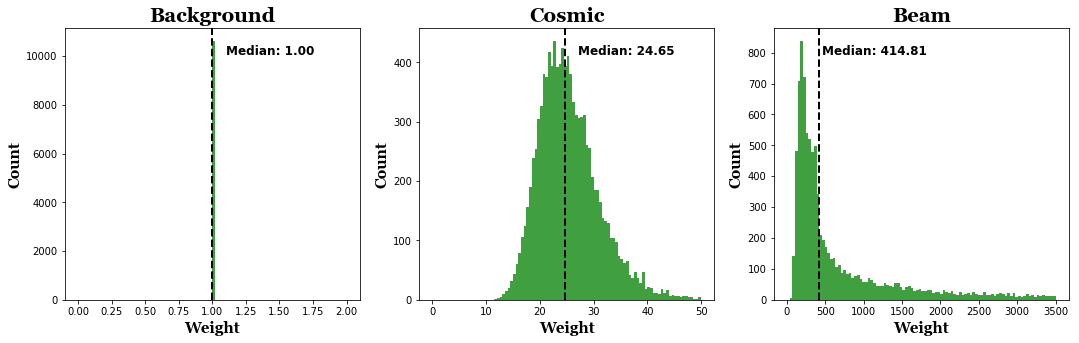

In [6]:
ranges = [(0,2), (0,50), (0, 3500)]
plot_weights(weights, ranges, "plots/weights.pdf")

In [7]:
coefficients = [1.0, 25.0, 415.0]

In [8]:
my_gen = DataSequence(training_feature_file, training_label_file)
X, y = my_gen.__getitem__(0)

(1, 480, 480, 1)
(480, 480)
(1, 480, 480, 3)
(480, 480)


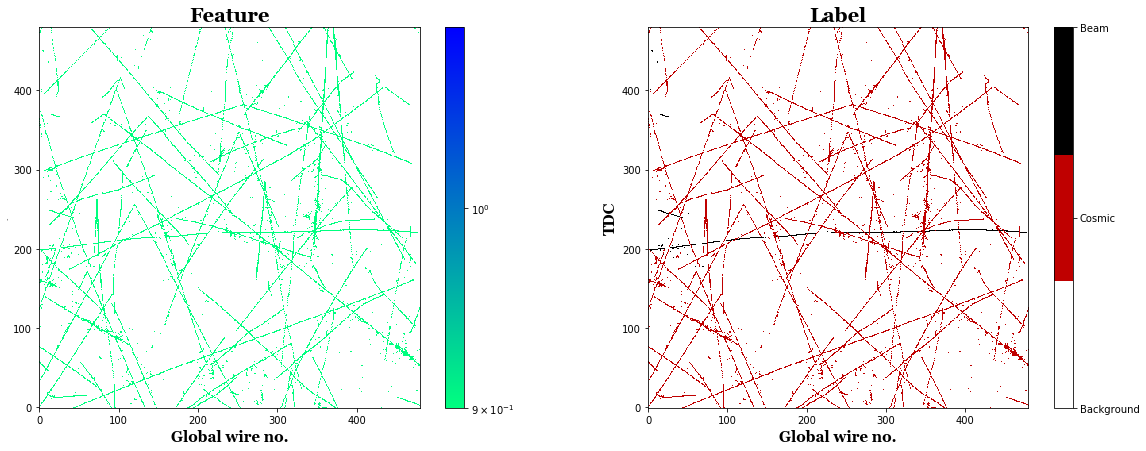

In [9]:
print(X.shape)
feature_image = X[0].reshape(image_width, image_height)
print(feature_image.shape)

print(y.shape)
label_image = np.argmax(y[0], axis=2)
print(label_image.shape)

plot_feature_label(feature_image, label_image, 'Feature', 'Label', 'plots/test.pdf')

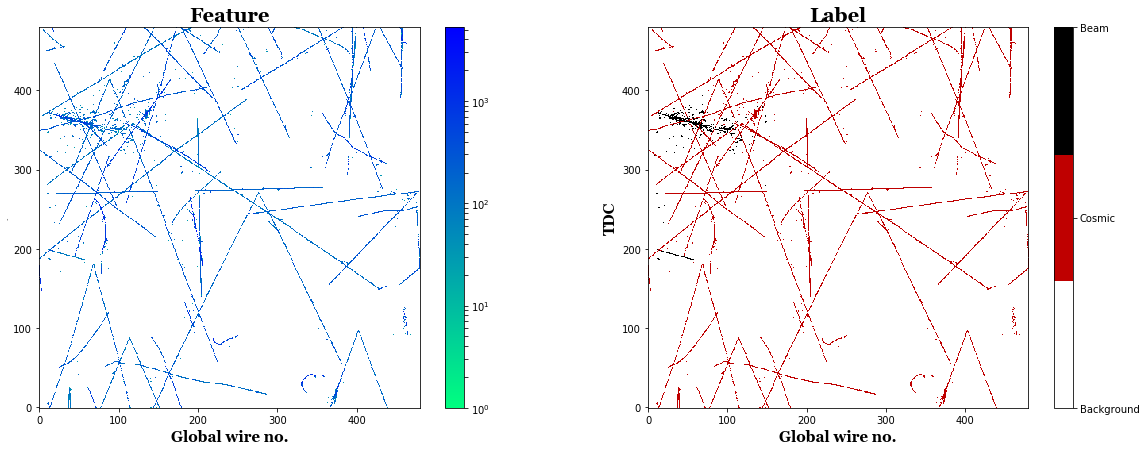

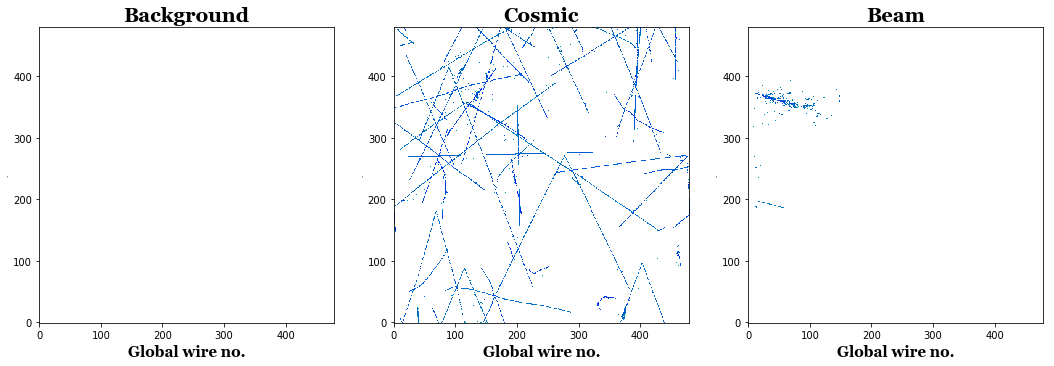

In [10]:
iter_data = get_data_generator(training_feature_file, training_label_file)
next(iter_data)
next(iter_data)
X, y = next(iter_data)

feature_image = X.reshape(image_width, image_height)
label_image = y.reshape(image_width, image_height)
plot_feature_label(feature_image, label_image, 'Feature', 'Label', 'plots/feature_label.pdf')
plot_categories(feature_image, label_image, 'plots/bkg_cosmic_beam.pdf')

# Build U-net model

In [11]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.activations import softmax

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # First layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # Vontracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # Expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax') (c9)        
    
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
import tensorflow as tf
from keras import backend as K

def weighted_loss(num_classes, coefficients):
    """
    Gets weighted categorical cross entropy.
    Use this loss function with median frequency coefficients weights for class balance.
    """    
    coefficients = tf.constant(coefficients)
    num_classes = tf.constant(num_classes)

    def loss(labels, logits):
        with tf.name_scope('loss_1'):
            logits = tf.reshape(logits, (-1, num_classes))
            epsilon = tf.constant(value=1e-10)

            logits = logits + epsilon
            # consturct one-hot label array
            labels = tf.to_float(tf.reshape(labels, (-1, num_classes)))
            softmax = tf.nn.softmax(logits)
            
            cross_entropy = -tf.reduce_sum(tf.multiply(labels * tf.log(softmax + epsilon), 
                                                       coefficients), reduction_indices=[1])
            cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')

            tf.add_to_collection('losses', cross_entropy_mean)
            loss = tf.add_n(tf.get_collection('losses'), name='total_loss')
            #loss = cross_entropy_mean
        return loss
    return loss

def mean_iou(y_true, y_pred):
    """
    Calculate per-step mean Intersection-Over-Union (mIOU).
    Computes the IOU for each semantic class and then computes the average over classes.
    """
    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, num_classes)
    K.get_session().run(tf.local_variables_initializer())
    with tf.control_dependencies([up_opt]):
        score = tf.identity(score)
    return score

In [13]:
input_img = Input((image_height, image_width, image_depth))
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer = 'adam',
              loss=weighted_loss(num_classes, coefficients),
              metrics = [mean_iou])
#model.summary()

In [14]:
batch_size = 10

# Stop training when a monitored quantity has stopped improving after 20 epochs
early_stop = EarlyStopping(patience=20, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=3, cooldown=3, verbose=1)

# Save the best model after every epoch
check_point = ModelCheckpoint(filepath='saved_models/model_and_weights.hdf5', 
                              save_best_only=True, verbose=1)

train_gen = DataSequence(feature_file=training_feature_file, 
                           label_file=training_label_file,  
                           max_index=n_training, 
                           batch_size=batch_size)

val_gen = DataSequence(feature_file=validation_feature_file, 
                         label_file=validation_label_file, 
                         max_index=n_validation, 
                         batch_size=batch_size)
    
test_gen = DataSequence(feature_file=testing_feature_file, 
                          label_file=testing_label_file, 
                          max_index=n_testing, 
                          batch_size=batch_size)

In [15]:
epochs = 2

history = model.fit_generator(train_gen, 
                              steps_per_epoch = n_training//batch_size,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps= n_validation//batch_size,
                              verbose=1,
                              callbacks=[check_point, early_stop, reduce_lr])

Epoch 1/2
3/3 [==============================] - 507s 169s/step - loss: 0.1603 - mean_iou: 0.3271 - val_loss: 0.2780 - val_mean_iou: 0.4975

Epoch 00001: val_loss improved from inf to 0.27802, saving model to saved_models/model_and_weights.hdf5
Epoch 2/2
3/3 [==============================] - 449s 150s/step - loss: 0.1483 - mean_iou: 0.5716 - val_loss: 0.2765 - val_mean_iou: 0.5620

Epoch 00002: val_loss improved from 0.27802 to 0.27651, saving model to saved_models/model_and_weights.hdf5


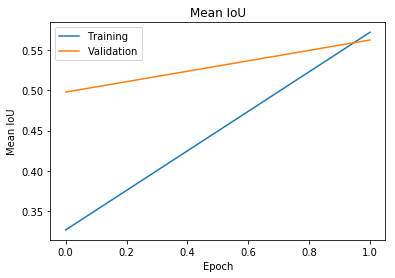

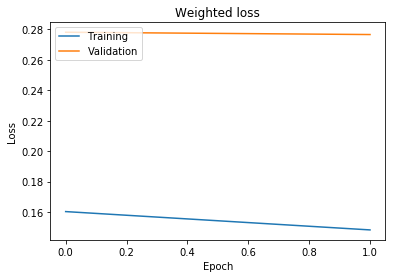

In [16]:
# Summarize history for IoU
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('plots/model_accuracy.pdf', bbox_inches='tight')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Weighted loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('plots/model_loss.pdf', bbox_inches='tight')
plt.show()

In [17]:
# Load the model with the best classification accuracy on the validation set
model.load_weights('saved_models/model_and_weights.hdf5')

In [18]:
iter_data = iter(get_data_generator(testing_feature_file, testing_label_file))
X, y = next(iter_data)
print(X.shape)
print(y.shape)
X_procesed = preprocess_feature(X)
print(X_procesed.shape)
predictions = model.predict_on_batch(X_procesed)
print(predictions.shape)

y_reshaped = preprocess_label(y)
print(y_reshaped.shape)

(230400,)
(230400,)
(1, 480, 480, 1)
(1, 480, 480, 3)
(1, 480, 480, 3)


In [19]:
prediction_max = np.argmax(predictions, axis=3)
print(prediction_max.shape)

(1, 480, 480)


In [20]:
def intersection_over_union(y_true, y_pred, epsilon=1e-6):
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true + y_pred)

    return ((2. * intersection + epsilon)/(union + epsilon))

def average_intersection_over_union(y_true, y_pred, n_classes=num_classes):
    """
    Average over classes and batch
    """
    n_preds = predictions.shape[0]
    print('Number of validation samples IoU evaulated on: {}'.format(n_preds))
    
    total_iou = 0
    for c in range(n_classes):
        average_over_batch_iou = intersection_over_union(y_true[:,:,:,c], y_pred[:,:,:,c])/n_preds
        print('Average IoU for {} is: {:.3f}'.format(categories_name[c], average_over_batch_iou))
        total_iou += average_over_batch_iou
        
    print('Global average IoU is: {:.3f}'.format(total_iou/n_classes))

average_intersection_over_union(y_reshaped, predictions)

Number of validation samples IoU evaulated on: 1
Average IoU for Background is: 0.923
Average IoU for Cosmic is: 0.041
Average IoU for Beam is: 0.014
Global average IoU is: 0.326


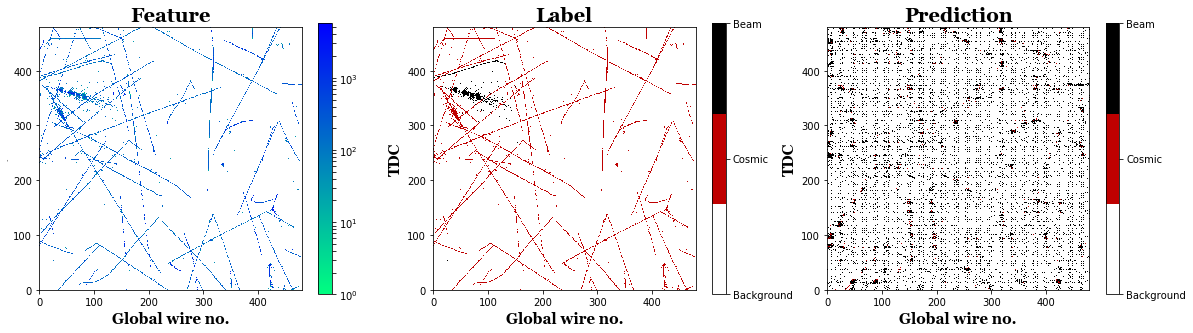

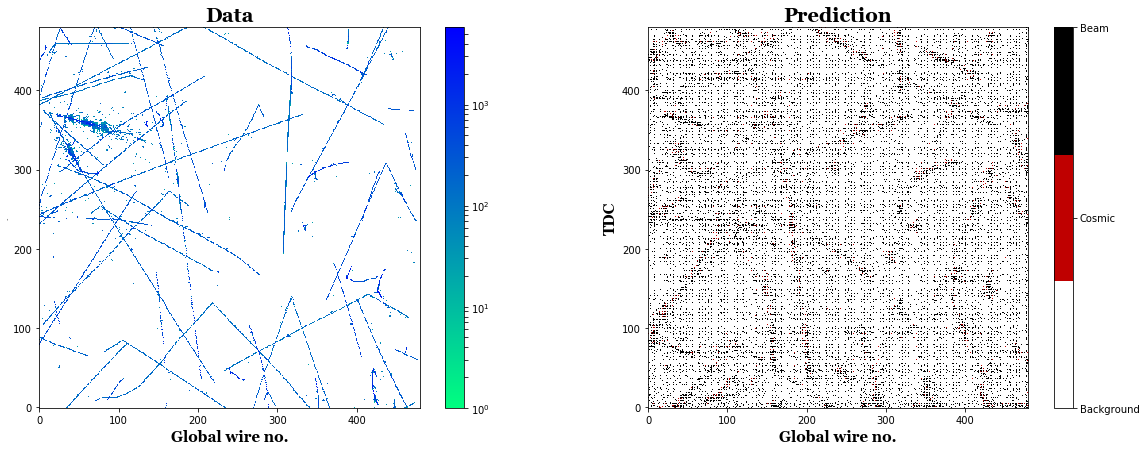

In [23]:
feature_image = X.reshape(image_width, image_height)
label_image = y.reshape(image_width, image_height)
prediction_image = prediction_max.reshape(image_width, image_height)

plot_feature_label_prediction(feature_image, label_image, prediction_image, 
                              'Feature', 'Label', 'Prediction', 'plots/feature_label_prediction.pdf')

plot_feature_label(feature_image, prediction_image, 
                   'Data', 'Prediction', 'plots/data_prediction.pdf')